In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#필요한 lib으로 한번만 하고, jupyter환경에선 다신 실행 안하셔도되고, colab에선 실행할 때마다 해주심 됩니다.
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 4.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=d68189054d01189246b33f30d3e94d794583c171a8fd9387a21addc7d88f0c14
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.1 MB/s eta 0:00:00


In [ ]:
# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn-v0_8') # 이 위에 코드를 실행하면 여러 테마가 있으니 마음껏 바꾸셔도 됩니다.
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
import lightgbm
import xgboost as xgb
import ngboost
import catboost

from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix


from dateutil import tz

import shap
import skimage


# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.options.display.max_columns = 400
pd.set_option('display.max_colwidth', None)

<Figure size 1600x800 with 0 Axes>

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/model/4.10_obj_modi.csv'
df = pd.read_csv(path)
df

,Unnamed: 0,installment,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,annual_inc,dti,fico_range_high,fico_range_low,funded_amnt_inv,grade,int_rate,loan_amnt,mort_acc,num_accts_ever_120_pd,issue_d_year,issue_d_month,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,target
0,1,680.82,126.0,277.0,0.0,0.0,110000.0,34.70,674.0,670.0,23200.000000,3,24.99,23200.0,2.0,0.0,2016,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,3,494.55,134.0,400.0,0.0,0.0,65000.0,17.74,824.0,820.0,16000.000000,7,7.07,16000.0,3.0,0.0,2017,10,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,4,146.10,226.0,130.0,2.0,2.0,50000.0,6.99,704.0,700.0,4500.000000,6,10.42,4500.0,1.0,0.0,2017,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,645.25,149.0,190.0,0.0,0.0,60000.0,28.94,679.0,675.0,20000.000000,6,9.99,20000.0,1.0,5.0,2015,9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,482.17,142.0,206.0,0.0,0.0,97523.0,10.31,739.0,735.0,18999.739941,4,17.97,19000.0,3.0,0.0,2019,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071205,1534129,662.45,232.0,144.0,0.0,0.0,60000.0,20.02,699.0,695.0,26450.000000,5,17.27,26500.0,1.0,0.0,2013,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1071206,1534131,133.78,151.0,36.0,0.0,0.0,33800.0,19.18,669.0,665.0,3600.000000,3,19.99,3600.0,1.0,0.0,2014,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1071207,1534132,583.89,125.0,216.0,0.0,0.0,71000.0,23.92,739.0,735.0,18875.000000,7,6.68,19000.0,5.0,0.0,2015,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1071208,1534133,329.65,25.0,99.0,0.0,0.0,44000.0,12.85,694.0,690.0,9600.000000,5,14.33,9600.0,1.0,0.0,2013,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# 결측치 있나 확인
df.isnull().sum()

Unnamed: 0                    0
installment                   0
mo_sin_old_il_acct            0
mo_sin_old_rev_tl_op          0
pub_rec                       0
pub_rec_bankruptcies          0
annual_inc                    0
dti                           0
fico_range_high               0
fico_range_low                0
funded_amnt_inv               0
grade                         0
int_rate                      0
loan_amnt                     0
mort_acc                      0
num_accts_ever_120_pd         0
issue_d_year                  0
issue_d_month                 0
home_ownership_MORTGAGE       0
home_ownership_NONE           0
home_ownership_OTHER          0
home_ownership_OWN            0
home_ownership_RENT           0
purpose_credit_card           0
purpose_debt_consolidation    0
purpose_educational           0
purpose_home_improvement      0
purpose_house                 0
purpose_major_purchase        0
purpose_medical               0
purpose_moving                0
purpose_

In [ ]:
# 필요 없는 부분 제거
df.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
df

,installment,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,annual_inc,dti,fico_range_high,fico_range_low,funded_amnt_inv,grade,int_rate,loan_amnt,mort_acc,num_accts_ever_120_pd,issue_d_year,issue_d_month,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,target
0,680.82,126.0,277.0,0.0,0.0,110000.0,34.70,674.0,670.0,23200.000000,3,24.99,23200.0,2.0,0.0,2016,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,494.55,134.0,400.0,0.0,0.0,65000.0,17.74,824.0,820.0,16000.000000,7,7.07,16000.0,3.0,0.0,2017,10,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,146.10,226.0,130.0,2.0,2.0,50000.0,6.99,704.0,700.0,4500.000000,6,10.42,4500.0,1.0,0.0,2017,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,645.25,149.0,190.0,0.0,0.0,60000.0,28.94,679.0,675.0,20000.000000,6,9.99,20000.0,1.0,5.0,2015,9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,482.17,142.0,206.0,0.0,0.0,97523.0,10.31,739.0,735.0,18999.739941,4,17.97,19000.0,3.0,0.0,2019,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071205,662.45,232.0,144.0,0.0,0.0,60000.0,20.02,699.0,695.0,26450.000000,5,17.27,26500.0,1.0,0.0,2013,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1071206,133.78,151.0,36.0,0.0,0.0,33800.0,19.18,669.0,665.0,3600.000000,3,19.99,3600.0,1.0,0.0,2014,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1071207,583.89,125.0,216.0,0.0,0.0,71000.0,23.92,739.0,735.0,18875.000000,7,6.68,19000.0,5.0,0.0,2015,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1071208,329.65,25.0,99.0,0.0,0.0,44000.0,12.85,694.0,690.0,9600.000000,5,14.33,9600.0,1.0,0.0,2013,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# 우선 랜덤하게 data_split하고 돌려봄 6:2:2
df_train, df_test = train_test_split(df, test_size = .2, train_size = .8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [ ]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
x_data = list(df.columns)
x_data.remove('target')

In [ ]:
x_data

['installment',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'pub_rec',
 'pub_rec_bankruptcies',
 'annual_inc',
 'dti',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt_inv',
 'grade',
 'int_rate',
 'loan_amnt',
 'mort_acc',
 'num_accts_ever_120_pd',
 'issue_d_year',
 'issue_d_month',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'term_ 60 months',
 'addr_state_AL',
 'addr_state_AR',
 'addr_state_AZ',
 'addr_state_CA',
 'addr_state_CO',
 'addr_state_CT',
 'addr_state_DC',
 'addr_state_DE',
 'addr_state_FL',
 'addr_state_GA',
 'addr_state_HI',
 'addr_state_IA',
 'addr_state_ID',
 'addr_state_IL',
 'a

In [ ]:
X_train = df_train[x_data]
y_train = df_train['target']

X_test = df_validation[x_data]
y_test = df_validation['target']
# 하나하나 선택해도 되지만, 필요없는 columns은 진작에 삭제해버려도 좋을듯
# Target은 Survived

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

xgboost = Train(XGBClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=50, max_depth=5, num_leaves = 50), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), X_train, y_train, X_test, y_test)
#ngb = Train(NGBClassifier(n_estimators=50, verbose=False, natural_gradient=False), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:12

Prediction time: 
Execution Time: 00:00:01
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 126375, number of negative: 516351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 642726, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196623 -> initscore=-1.407533
[LightGBM] [Info] Start training from score -1.407533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
models = [
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat)
    #('NgBoost', ngb),
]

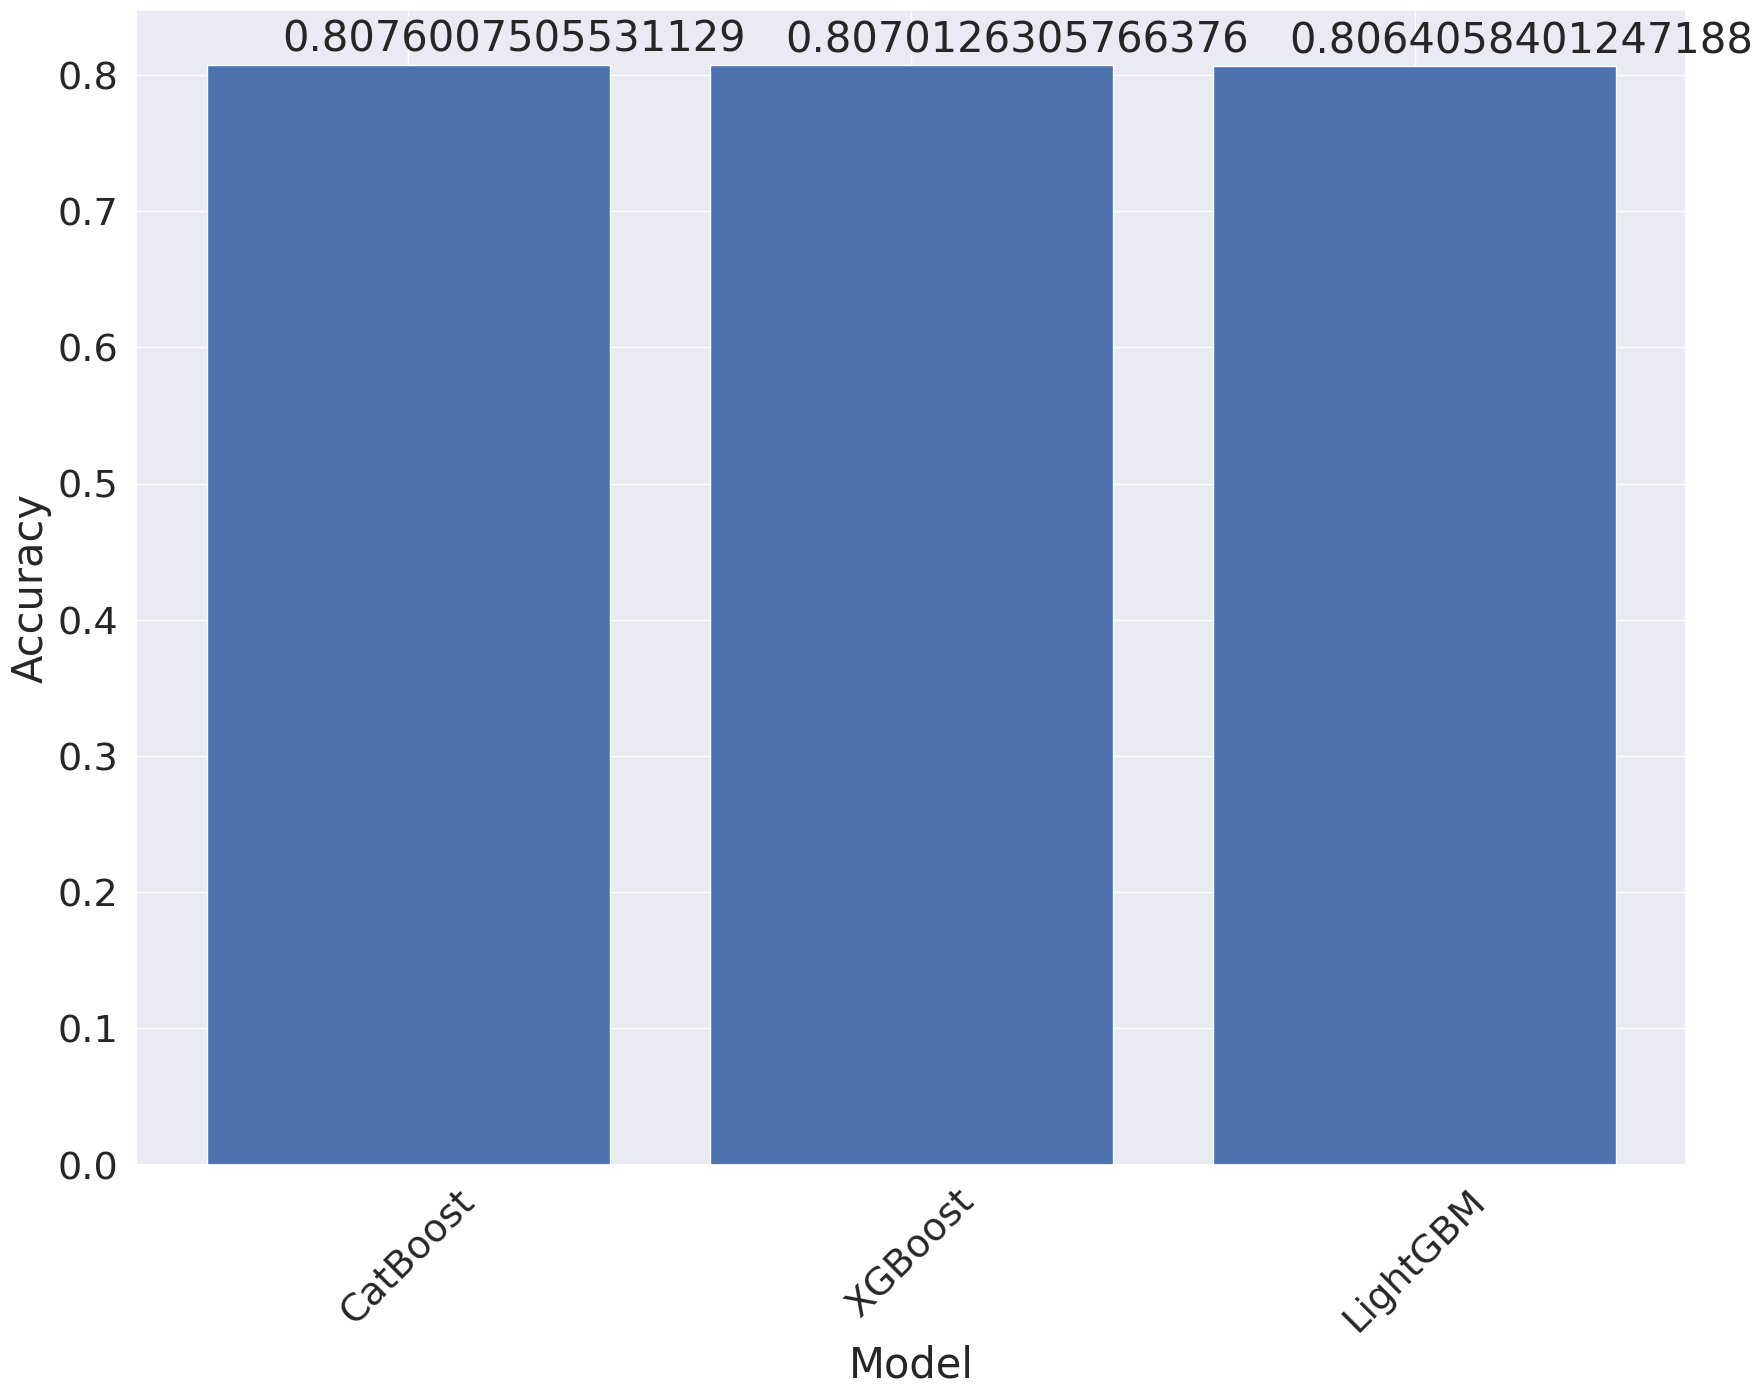

In [ ]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

In [ ]:
# test 데이터 predict 구하기
# xgb
#xgboost.predict(df_test[x_data])
# lgb
#lgb.predict(df_test[x_data])
# cat
cat.predict(df_test[x_data])

array([0, 1, 1, ..., 0, 0, 1])

## Confusion matrix

In [ ]:
confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(X_test)
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for XGBoost
[[169786   2437]
 [ 38909   3110]]

Confusion Matrix for LightGBM
[[170696   1527]
 [ 39949   2070]]

Confusion Matrix for CatBoost
[[169861   2362]
 [ 38858   3161]]



각 연도별 데이터를 dict형태로 정리해서 각각 예측한 값을 confusion으로 비교

In [ ]:
year = list(df['issue_d_year'].unique())

In [30]:
year

[2016,
 2017,
 2015,
 2019,
 2018,
 2014,
 2013,
 2020,
 2012,
 2008,
 2011,
 2010,
 2009,
 2007]

In [ ]:
year_dict = {}
for x in year:
    year_dict[x] = df[df['issue_d_year'] == x]


In [34]:
year_dict[2019].drop('target', axis = 1)

,installment,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,annual_inc,dti,fico_range_high,fico_range_low,funded_amnt_inv,grade,int_rate,loan_amnt,mort_acc,num_accts_ever_120_pd,issue_d_year,issue_d_month,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
4,482.17,142.0,206.0,0.0,0.0,97523.0,10.31,739.0,735.0,18999.739941,4,17.97,19000.0,3.0,0.0,2019,5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,306.64,133.0,286.0,0.0,0.0,150000.0,23.00,699.0,695.0,12475.000000,5,16.40,12500.0,1.0,0.0,2019,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,443.49,160.0,515.0,0.0,0.0,48000.0,15.33,664.0,660.0,12750.000000,5,15.24,12750.0,0.0,3.0,2019,12,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,1256.97,60.0,77.0,1.0,1.0,140000.0,6.91,684.0,680.0,40000.000000,7,8.19,40000.0,2.0,0.0,2019,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79,240.27,238.0,164.0,0.0,0.0,46000.0,22.83,764.0,760.0,7000.000000,5,14.30,7000.0,0.0,0.0,2019,9,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071121,277.84,154.0,103.0,1.0,1.0,120000.0,10.15,694.0,690.0,8400.000000,6,11.71,8400.0,0.0,1.0,2019,10,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1071158,425.73,72.0,71.0,1.0,1.0,82000.0,15.76,669.0,665.0,13000.000000,6,11.02,13000.0,2.0,0.0,2019,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1071170,1256.97,121.0,201.0,0.0,0.0,85000.0,4.86,709.0,705.0,40000.000000,7,8.19,40000.0,5.0,0.0,2019,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1071179,648.40,83.0,85.0,1.0,1.0,57000.0,19.18,694.0,690.0,17950.000000,5,17.74,18000.0,0.0,0.0,2019,7,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(year_dict[2007].drop('target', axis = 1))
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(year_dict[2007]['target'], y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for XGBoost
[[210   2]
 [ 75  11]]

Confusion Matrix for LightGBM
[[212   0]
 [ 86   0]]

Confusion Matrix for CatBoost
[[208   4]
 [ 82   4]]



In [36]:
for year in range(2007,2021):
    confusion_matrices = {}
    # 각 모델에 대한 전퓨전 매트릭스 상성
    for name, model in models:
        # 모델의 예측값 얻기
        y_pred = model.predict(year_dict[year].drop('target', axis = 1))
        # 컨퓨전 매트릭스 생성
        cm = confusion_matrix(year_dict[year]['target'], y_pred)
        # 딕셔너리에 저장
        confusion_matrices[name] = cm

    # 컨퓨전 매트릭스 출력
    for name, cm in confusion_matrices. items():
        print(f"{year} Confusion Matrix for {name}")
        print (cm)
        print()

2007 Confusion Matrix for XGBoost
[[210   2]
 [ 75  11]]

2007 Confusion Matrix for LightGBM
[[212   0]
 [ 86   0]]

2007 Confusion Matrix for CatBoost
[[208   4]
 [ 82   4]]

2008 Confusion Matrix for XGBoost
[[1123    2]
 [ 288    3]]

2008 Confusion Matrix for LightGBM
[[1125    0]
 [ 291    0]]

2008 Confusion Matrix for CatBoost
[[1125    0]
 [ 291    0]]

2009 Confusion Matrix for XGBoost
[[2634    0]
 [ 415    3]]

2009 Confusion Matrix for LightGBM
[[2634    0]
 [ 418    0]]

2009 Confusion Matrix for CatBoost
[[2634    0]
 [ 418    0]]

2010 Confusion Matrix for XGBoost
[[6124    5]
 [ 971    4]]

2010 Confusion Matrix for LightGBM
[[6129    0]
 [ 974    1]]

2010 Confusion Matrix for CatBoost
[[6127    2]
 [ 973    2]]

2011 Confusion Matrix for XGBoost
[[10444    10]
 [ 1815    22]]

2011 Confusion Matrix for LightGBM
[[10453     1]
 [ 1835     2]]

2011 Confusion Matrix for CatBoost
[[10451     3]
 [ 1829     8]]

2012 Confusion Matrix for XGBoost
[[26544    25]
 [ 5136    

## Shap 추가
출처 : https://todayisbetterthanyesterday.tistory.com/57

In [ ]:
explainer = shap.TreeExplainer(cat) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)